In [1]:
import torch 
import os 
from subprocess import call
from matplotlib.pyplot import imshow
from miscc.config import cfg,cfg_from_file
import pprint
from miscc.utils import weights_init,mkdir_p
import torchfile
import numpy as np 
from torch.autograd import Variable
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt 
import random 

cfg_from_file("cfg/demo-coco.yml")
cfg.GPU_ID = '0'
cfg.TRAIN.BATCH_SIZE = 16
model="coco"
s_gpus = cfg.GPU_ID.split(',')
gpus = [int(ix) for ix in s_gpus]
torch.cuda.set_device(gpus[0])
pprint.pprint(cfg)

{'CONFIG_NAME': 'stageII',
 'CUDA': True,
 'DATASET_NAME': 'birds',
 'DATA_DIR': '../data/coco',
 'EMBEDDING_TYPE': 'cnn-rnn',
 'GAN': {'CONDITION_DIM': 128, 'DF_DIM': 96, 'GF_DIM': 192, 'R_NUM': 2},
 'GPU_ID': '0',
 'IMSIZE': 256,
 'NET_D': '',
 'NET_G': '../models/coco/netG_epoch_90.pth',
 'STAGE': 2,
 'STAGE1_G': '',
 'TEXT': {'DIMENSION': 1024},
 'TRAIN': {'BATCH_SIZE': 16,
           'COEFF': {'KL': 2.0},
           'DISCRIMINATOR_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'LR_DECAY_EPOCH': 600,
           'MAX_EPOCH': 600,
           'PRETRAINED_EPOCH': 600,
           'PRETRAINED_MODEL': '',
           'SNAPSHOT_INTERVAL': 50},
 'VIS_COUNT': 64,
 'WORKERS': 4,
 'Z_DIM': 100}


In [2]:
def load_network_stageII():
        from model import STAGE1_G, STAGE2_G, STAGE2_D

        Stage1_G = STAGE1_G()
        netG = STAGE2_G(Stage1_G)
        netG.apply(weights_init)

        if cfg.NET_G != '':
            state_dict = \
                torch.load(cfg.NET_G,
                           map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load from: ', cfg.NET_G)
        elif cfg.STAGE1_G != '':
            state_dict = \
                torch.load(cfg.STAGE1_G,
                           map_location=lambda storage, loc: storage)
            netG.STAGE1_G.load_state_dict(state_dict)
            print('Load from: ', cfg.STAGE1_G)
        else:
            print("Please give the Stage1_G path")
            return

        netD = STAGE2_D()
        netD.apply(weights_init)
        if cfg.NET_D != '':
            state_dict = \
                torch.load(cfg.NET_D,
                           map_location=lambda storage, loc: storage)
            netD.load_state_dict(state_dict)
            print('Load from: ', cfg.NET_D)

        if cfg.CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD
    

In [4]:
def sample(datapath):
        
        netG, _ = load_network_stageII()
        netG.eval()

        # Load text embeddings generated from the encoder
        t_file = torchfile.load(datapath)
        captions_list = t_file.raw_txt
        embeddings = np.concatenate(t_file.fea_txt, axis=0)
        num_embeddings = len(captions_list)
        print('Successfully load sentences from: ', datapath)
        print('Total number of sentences:', num_embeddings)
        print('num_embeddings:', num_embeddings, embeddings.shape)
        # path to save generated samples
        save_dir = cfg.NET_G[:cfg.NET_G.find('.pth')]
        mkdir_p(save_dir)

        batch_size = cfg.TRAIN.BATCH_SIZE
        nz = cfg.Z_DIM
        noise = Variable(torch.FloatTensor(batch_size, nz))
        if cfg.CUDA:
            noise = noise.cuda()
        count = 0
        #765 1021 1212 2287 2990 928 1629 138 2690 2304 2954 2462 1485 327 1451
        embeddings_batch=[]
        randoms = random.sample(range(0,2999),batch_size)
        
        fixed = [765,1021,1212,2287,2990,928,1629,138,2690,2304,2954,2462,1485,327,1451,122]
        
        for i  in fixed:
            embeddings_batch.append(embeddings[i])
            
        txt_embedding = Variable(torch.FloatTensor(embeddings_batch))
        if cfg.CUDA:
            txt_embedding = txt_embedding.cuda()
                
        noise.data.normal_(0, 1)
        inputs = (txt_embedding, noise)
        _, fake_imgs, mu, logvar = \
                nn.parallel.data_parallel(netG, inputs,gpus)
        file = open("val_captions.txt","r")
        lines = file.readlines()
            
        for i,x in enumerate(fixed):
            save_name = '%s/%d.png' % (save_dir, count + i)
            im = fake_imgs[i].data.cpu().numpy()
            im = (im + 1.0) * 127.5
            im = im.astype(np.uint8)
            #print('im', im.shape)
            im = np.transpose(im, (1, 2, 0))
            #print('im', im.shape)
            im = Image.fromarray(im)
            plt.figure()
            plt.title(lines[x]+str(x))
            plt.imshow(im)
            im.save(save_name)
            
        

Load from:  ../models/coco/netG_epoch_90.pth
Successfully load sentences from:  val_captions.t7
Total number of sentences: 40470
num_embeddings: 40470 (40470, 1024)


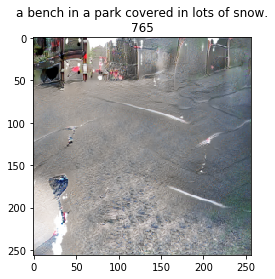

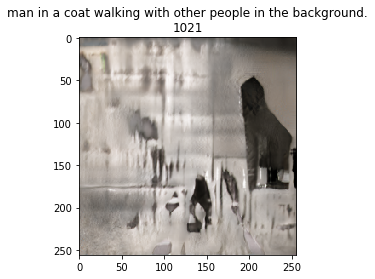

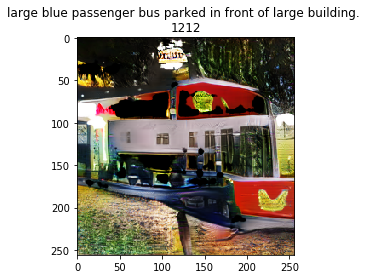

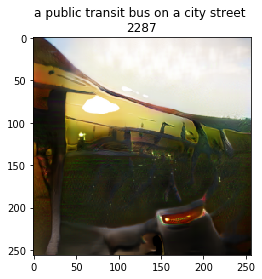

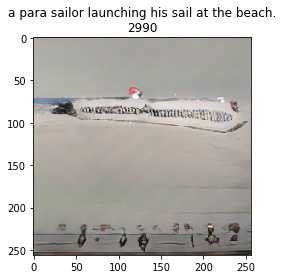

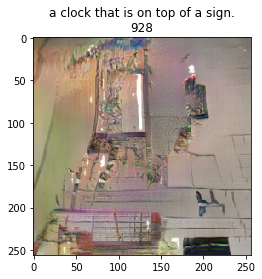

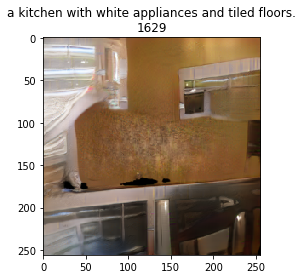

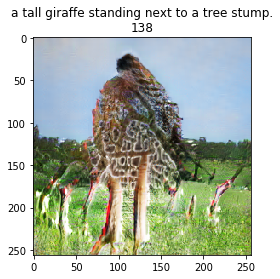

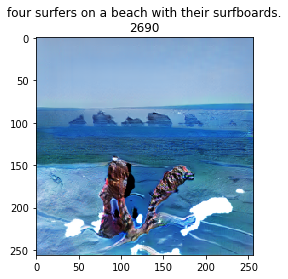

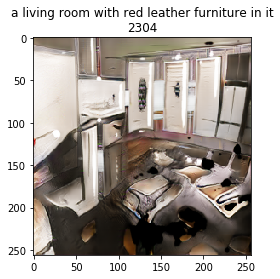

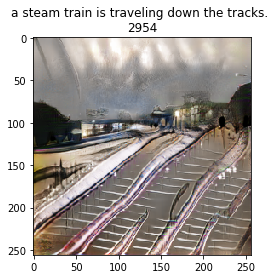

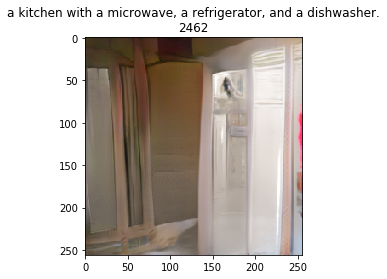

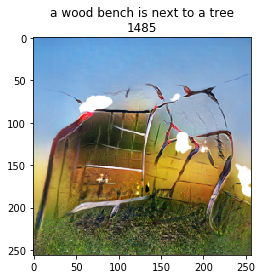

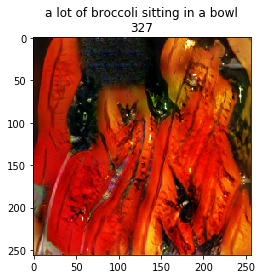

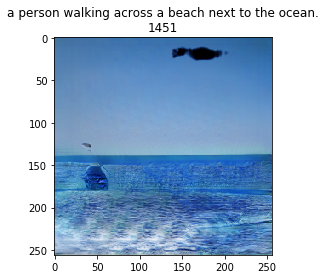

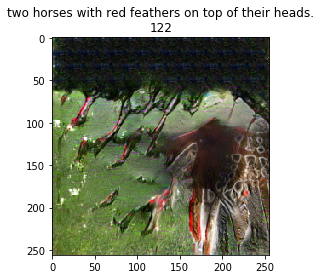

In [5]:
sample("val_captions.t7")